In [7]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
from hydra.utils import instantiate
from hydra import initialize, compose
import hydra
import wandb
from omegaconf import OmegaConf
import copy

from model.rbm.rbm import RBM
from model.rbm.rbm_torch import RBMtorch
from scripts.run import setup_model, load_model_instance

import dwave_networkx as dnx
from dwave.system import DWaveSampler
import networkx as nx




In [ ]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path="config")
cfg=compose(config_name="config.yaml")
wandb.init(tags = [cfg.data.dataset_name], project=cfg.wandb.project, entity=cfg.wandb.entity, config=OmegaConf.to_container(cfg, resolve=True), mode='disabled')

In [ ]:
RBM = RBM(cfg)

[17:44:44.170] INFO   dwave.cloud.client.base                           Fetching definitions of all available solvers


[17:44:44.212] INFO   dwave.cloud.client.base                           Received solver data for 7 solver(s).
[17:44:44.455] INFO   dwave.cloud.client.base                           Adding solver StructuredSolver(id='Advantage_system4.1')
[17:44:44.512] INFO   dwave.cloud.client.base                           Adding solver StructuredSolver(id='Advantage_system6.4')
[17:44:44.562] INFO   dwave.cloud.client.base                           Adding solver StructuredSolver(id='Advantage2_system1.5')


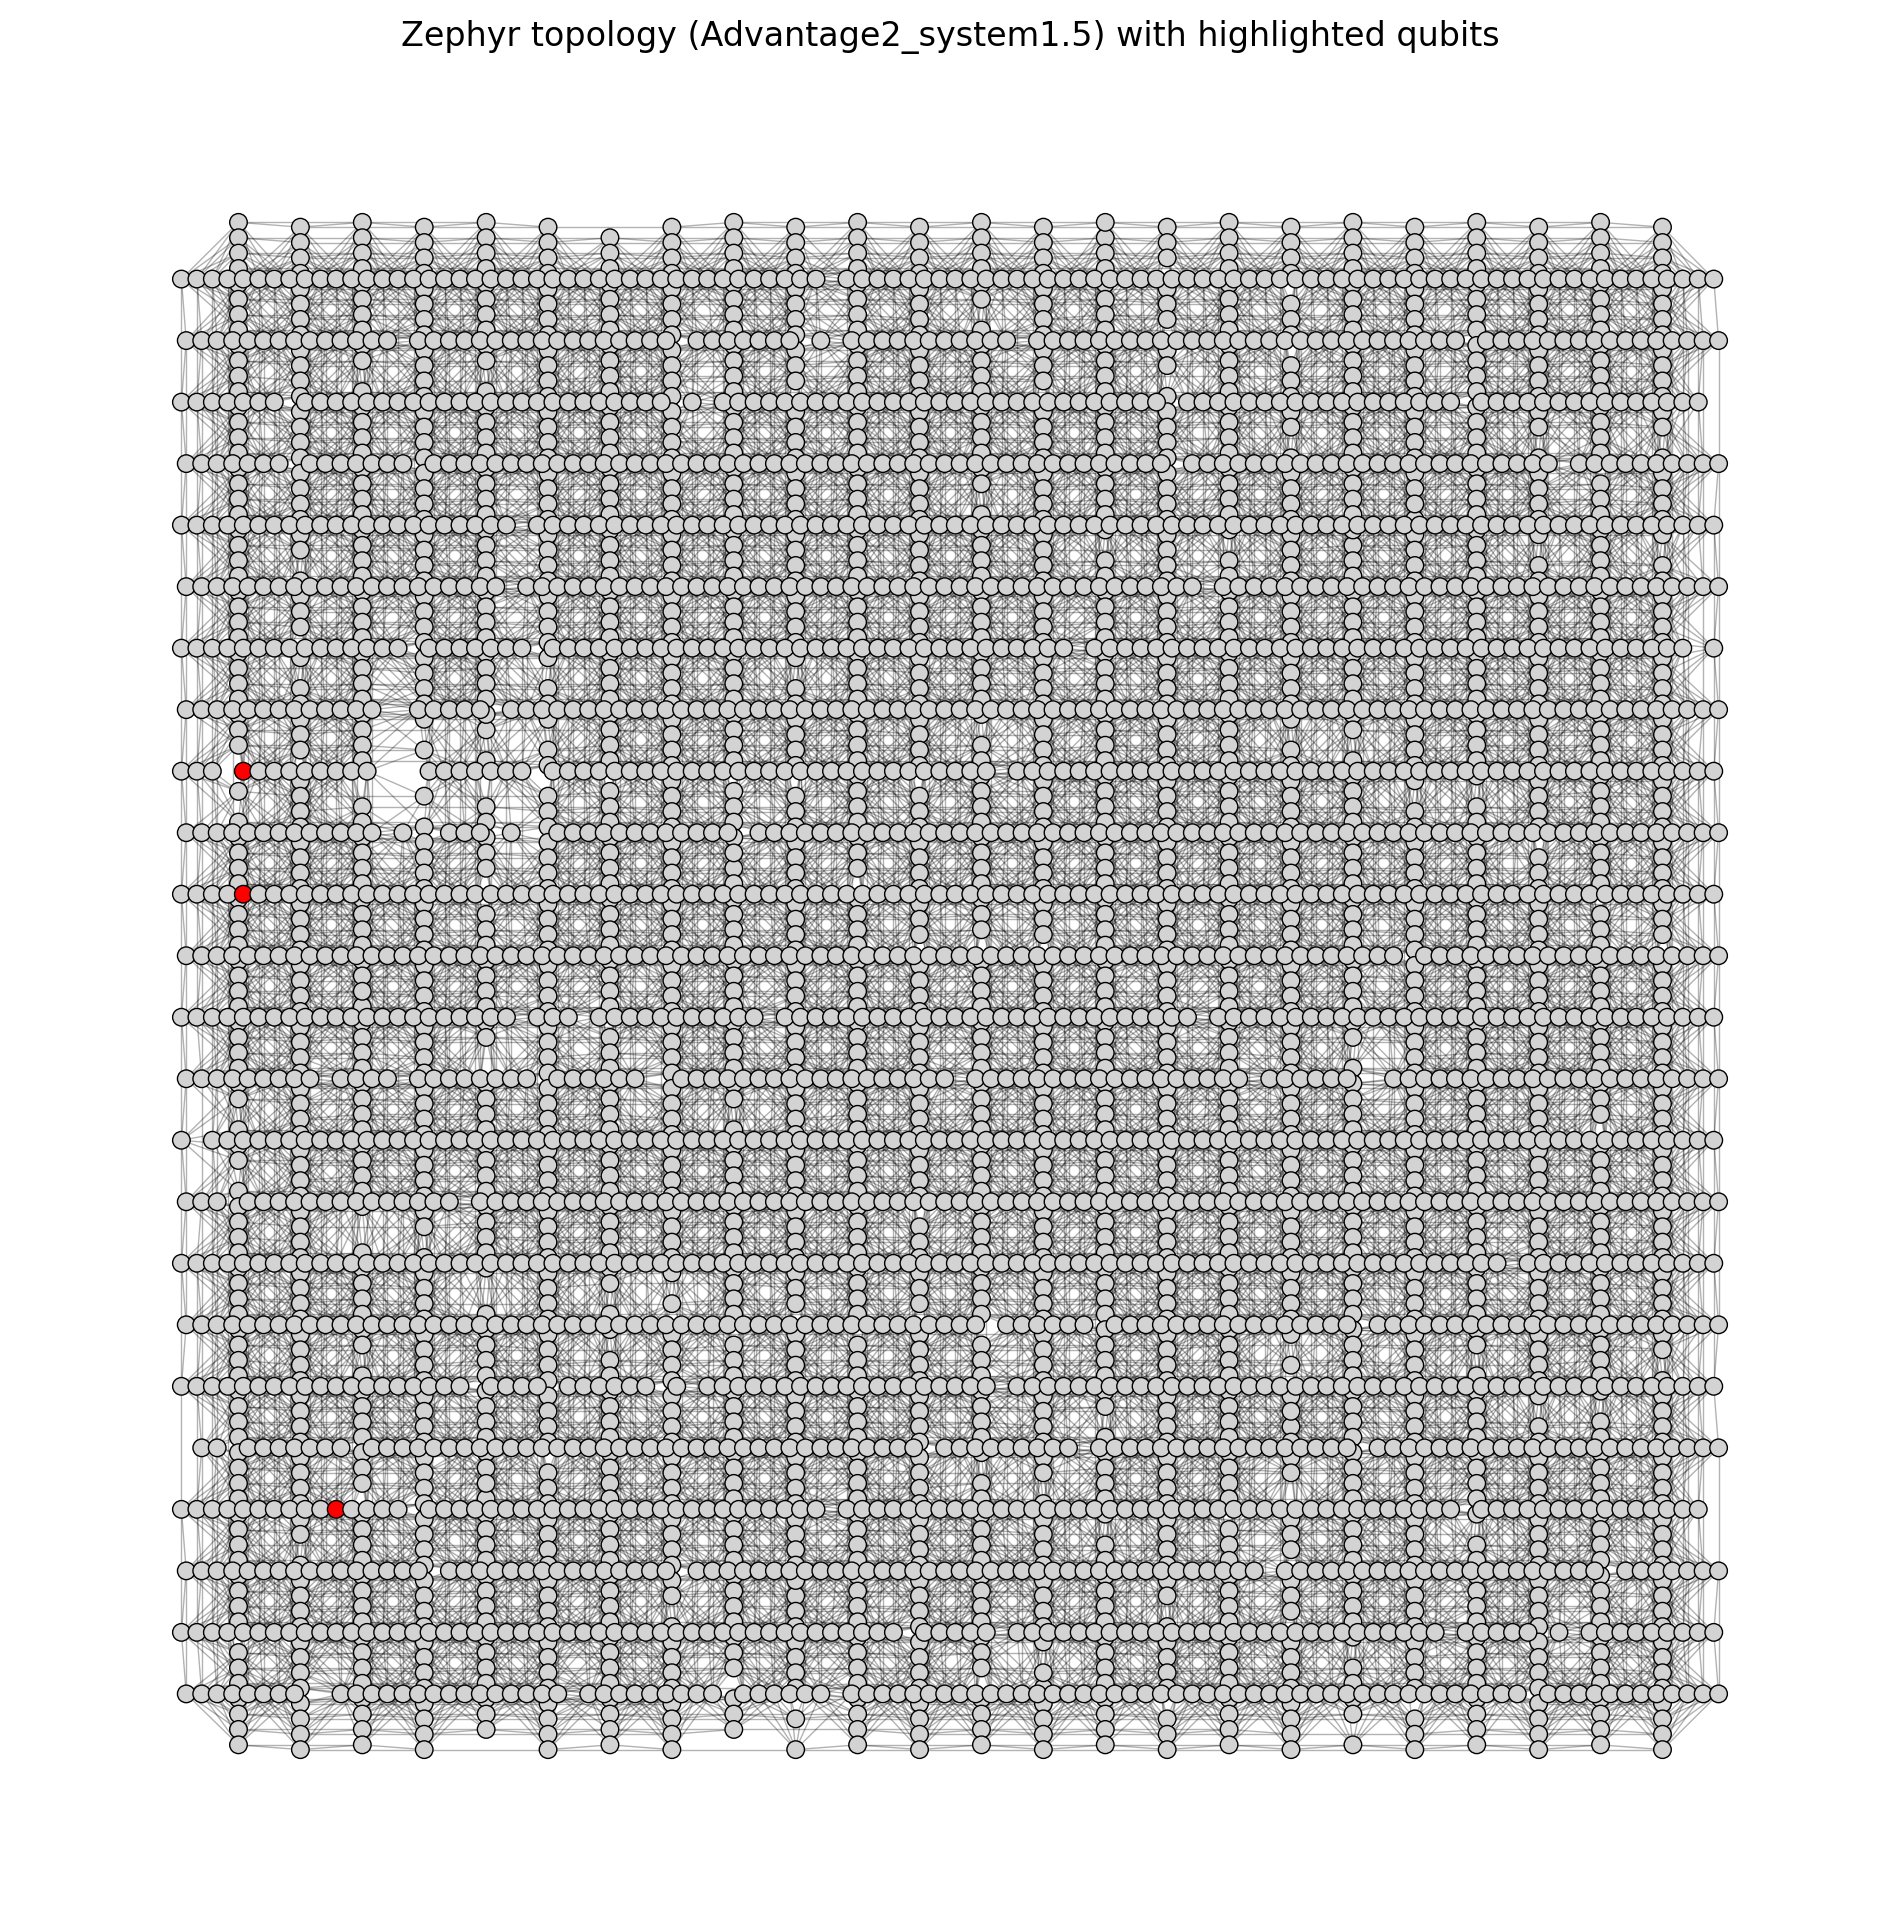

In [8]:
# --- Configure this list with your chosen qubits (indices from the sampler.nodelist) ---
chosen_qubits = [100, 101, 250]  # Example qubit indices; replace with your list

# Get a live Zephyr sampler
sampler = DWaveSampler(solver={'topology__type': 'zephyr'})
m, t = sampler.properties['topology']['shape']

# Build a graph of active hardware
G = dnx.zephyr_graph(m, t,
                     node_list=sampler.nodelist,
                     edge_list=sampler.edgelist)

# Get 2D coordinates for plotting
pos = dnx.zephyr_layout(G)

# Color nodes: red if in chosen_qubits, gray otherwise
node_colors = ['red' if n in chosen_qubits else 'lightgray' for n in G.nodes]

plt.figure(figsize=(12, 12))
nx.draw_networkx_edges(G, pos=pos, alpha=0.3, width=0.5)
nx.draw_networkx_nodes(G, pos=pos,
                       node_color=node_colors,
                       node_size=40,
                       linewidths=0.5,
                       edgecolors='black')

plt.title(f"Zephyr topology ({sampler.solver.name}) with highlighted qubits")
plt.axis('off')
plt.show()


In [ ]:
#config.wandb.watch = 0
new_model = True
if new_model:
    self = setup_model(cfg)
else:
    config = OmegaConf.load(cfg.config_path)
    config.gpu_list = cfg.gpu_list
    config.load_state = cfg.load_state
    self = setup_model(config)
    self._model_creator.load_state(config.run_path, self.device)


In [ ]:
#torch.autograd.set_detect_anomaly(True)
self.fit_vae(0)
self._save_model(name=str(0))

In [ ]:
self.model_creator.load_state("/tmp/autoencoderbase_0.pth", self.device, self.optimiser, self.model.prior.opt)

In [ ]:
torch.manual_seed(0)
manual_RBM = RBM(config)
manual_weights = manual_RBM.weight_dict

torch.manual_seed(0)
torch_RBM = RBMtorch(config)
torch_weights = torch_RBM.weight_dict

#check if two weight dicts are equal
assert manual_weights.keys() == torch_weights.keys()
for key in manual_weights.keys():
    assert torch.all(manual_weights[key] == torch_weights[key])
# print top values in both weight dicts
# print("Manual RBM weights:")
# print(manual_weights['02'][0])
# print("Torch RBM weights:")
# print(torch_weights['02'][0])

# calculate mock gradients
# manual_RBM.calculate_mock_gradient()
# torch_RBM.calculate_mock_gradient()

#generate dummy post_samples
torch.manual_seed(0)

n_samples = 10
n_nodes_p = config.rbm.latent_nodes_per_p
post_samples = [
    torch.randint(0, 2, (n_samples, n_nodes_p), dtype=torch.float32)
    for _ in range(4)
]

# Compute gradients with identical RNG sequences
with torch.random.fork_rng():
    torch.manual_seed(123)
    manual_RBM.gradient_rbm_centered(post_samples)

with torch.random.fork_rng():
    torch.manual_seed(123)
    torch_RBM.gradient_rbm_centered(post_samples)

# Compare with tolerances + diagnostics
for kind in ("bias", "weight"):
    for key in manual_RBM.grad[kind]:
        a = manual_RBM.grad[kind][key]
        b = torch_RBM.grad[kind][key]
        if not torch.allclose(a, b, rtol=1e-5, atol=1e-8):
            diff = (a - b).abs().max().item()
            print(f"{kind}.{key} differ, max|Δ|={diff}")

# use different optimizers
manual_RBM.initOpt()
manual_RBM.update_params()

torch_RBM.initOpt_torch()
torch_RBM.update_params_torch()

# print top values in both weight dicts
manual_weights = manual_RBM._weight_dict
torch_weights = torch_RBM.weight_dict
print("Manual RBM weights:")
print(manual_weights['02'][0])
print("Torch RBM weights:")
print(torch_weights['02'][0])

for i, group in enumerate(torch_RBM.opt.param_groups):
    print(f"Param group {i}")
    for p in group['params']:
        print("  id:", id(p), " shape:", p.shape, " requires_grad:", p.requires_grad)



# check if weights are equal
assert manual_weights.keys() == torch_weights.keys()
for key in manual_weights.keys():
    diff = (manual_weights[key] - torch_weights[key]).abs().max()
    print(f"Max diff for {key}: {diff}")


In [ ]:
torch.manual_seed(0)
rbm_torch = RBMtorch(config)
# Clone weights before update
before_update = {k: v.clone() for k, v in rbm_torch._weight_dict.items()}

# before step
p = rbm_torch._weight_dict['01']
print(id(p), p.storage().data_ptr())


# Perform optimizer step
rbm_torch.initOpt_torch()
rbm_torch.calculate_mock_gradient()
rbm_torch.update_params_torch()


rbm_torch.update_params_torch()

# Clone weights after update
after_update = {k: v.clone() for k, v in rbm_torch._weight_dict.items()}
# after step: these must be identical
q = rbm_torch._weight_dict['01']
print(id(q), q.storage().data_ptr())

# Check for changes
for k in before_update:
    changed = not torch.allclose(before_update[k], after_update[k])
    print(f"Weights for '{k}' updated: {changed}")


In [ ]:
class testRBM(RBM):
    def calculate_mock_gradient(self):
        """Creates a deterministic mock gradient for testing."""
        self.grad = {"bias": {}, "weight": {}}
        for key, param in self.bias_dict.items():
            self.grad["bias"][key] = torch.ones_like(param) * 0.1
        for key, param in self.weight_dict.items():
            self.grad["weight"][key] = torch.ones_like(param) * -0.05
RBMinitial = testRBM(config)


In [ ]:
rbm_custom = copy.deepcopy(RBMinitial)
rbm_custom.initOpt()
rbm_custom.calculate_mock_gradient()

initial_weight_01 = rbm_custom.weight_dict['01'].data.clone()
rbm_custom.update_params()
final_weight_custom = rbm_custom.weight_dict['01'].data.clone()

print(f"Initial Weight (Top 5 values): {initial_weight_01.flatten()[:5].tolist()}")
print(f"Final Weight (Top 5 values):   {final_weight_custom.flatten()[:5].tolist()}\n")

rbm_torch = copy.deepcopy(RBMinitial)
rbm_torch.initOpt_torch()
rbm_torch.calculate_mock_gradient()

initial_weight_01_torch = rbm_torch.weight_dict['01'].data.clone()
rbm_torch.update_params_torch()
final_weight_torch = rbm_torch.weight_dict['01'].data.clone()

print(f"Initial Weight (Top 5 values): {initial_weight_01_torch.flatten()[:5].tolist()}")
print(f"Final Weight (Top 5 values):   {final_weight_torch.flatten()[:5].tolist()}\n")


In [ ]:
print("--- Running Test 1: Custom AdamOpt (Adam with L2 Regularization) ---")
rbm_custom = copy.deepcopy(rbm_initial)
rbm_custom.initOpt()
rbm_custom.calculate_mock_gradient()

# Store initial weights for comparison
initial_weight_01 = rbm_custom.weight_dict['01'].data.clone()
rbm_custom.update_params()
final_weight_custom = rbm_custom.weight_dict['01'].data.clone()

print(f"Initial Weight (Top 5 values): {initial_weight_01.flatten()[:5].tolist()}")
print(f"Final Weight (Top 5 values):   {final_weight_custom.flatten()[:5].tolist()}\n")


# --- Test 2: PyTorch's Adam (AdamW) Implementation ---
print("--- Running Test 2: PyTorch `torch.optim.Adam` (AdamW) ---")
rbm_torch = copy.deepcopy(rbm_initial)
rbm_torch.initOpt_torch()
rbm_torch.calculate_mock_gradient()

# Store initial weights (should be identical to the other test)
initial_weight_01_torch = rbm_torch.weight_dict['01'].data.clone()
rbm_torch.update_params_torch()
final_weight_torch = rbm_torch.weight_dict['01'].data.clone()

print(f"Initial Weight (Top 5 values): {initial_weight_01_torch.flatten()[:5].tolist()}")
print(f"Final Weight (Top 5 values):   {final_weight_torch.flatten()[:5].tolist()}\n")

# --- Comparison and Conclusion ---
print("--- Comparison ---")
# Check if initial weights are identical
are_initial_weights_same = torch.allclose(initial_weight_01, initial_weight_01_torch)
print(f"Initial weights were identical: {are_initial_weights_same}")

# Check if final weights are identical
are_final_weights_same = torch.allclose(final_weight_custom, final_weight_torch)
print(f"Final weights are identical: {are_final_weights_same}")

if not are_final_weights_same:
    difference = torch.mean(torch.abs(final_weight_custom - final_weight_torch))
    print(f"Average absolute difference between final weights: {difference.item():.8f}")
    print("\nConclusion: The final weights are different, confirming the optimizer behaviors are not identical.")